# Importing Libraries

In [1]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
# from sklearn.cross_validation import StratifiedKFold 
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [3]:
# This final_features.csv is generated from the previous two iPython notebook generated locally 
# Using Kaggle for model is because limitation of local sys to train over large data
data = pd.read_csv('/kaggle/input/final-features-qqp/final_features.csv')
data.head()

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,3.969558,28.222729,36.632493,-9.604564,-1.282670,-15.204172,12.925817,-0.867089,22.081050,-15.542879
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,-23.952735,19.181594,38.195441,-21.501692,-19.197923,8.329967,4.524858,-12.455467,64.494825,-4.589959
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,16.818044,22.858728,49.634287,10.692153,-35.023456,-13.438970,-10.352275,6.024001,27.928444,-3.940404
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-8.076668,-8.661811,23.562781,18.113977,-22.750974,-21.712061,-1.793455,3.109173,1.629791,-27.379069
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,...,20.038354,-7.121922,29.326785,-3.158665,-28.051102,-10.691120,-9.676437,15.828423,12.214419,-15.689719


**The metric over which we will be evaluating our model is log-loss , therefore the value over which log loss can take values is "[0,inf]".
For threshold upper value we will train a random model which will replicate worst case scenerio condition now the log loss obtained via this random model.**


In [4]:
# First we will train over a sample of 30 per cent of actual data once concluded with which model to opt 
# Then we will train over entire data 
sample = data.sample(frac=0.3)
sample.shape

(121287, 221)

In [5]:
y_true = sample['is_duplicate']
sample.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(sample, y_true, test_size=0.33, random_state=42)

In [7]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((81262, 218), (40025, 218), (81262,), (40025,))

Log loss on test data using random model is : 0.8948741502669898


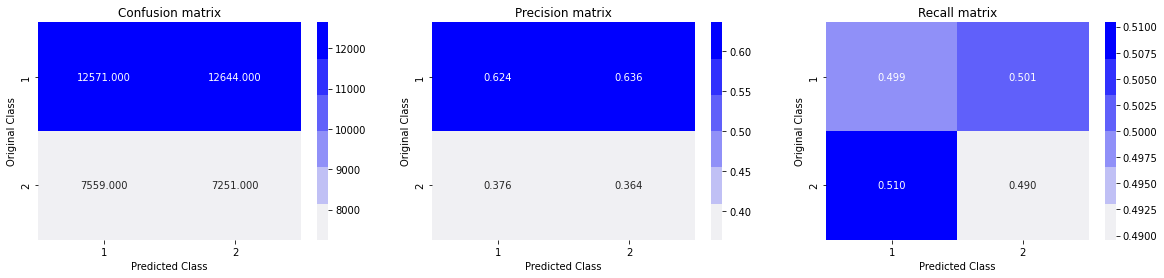

In [8]:
predicted_y = np.zeros((len(y_test),2))
for i in range(len(y_test)):
    rand_probs = np.random.rand(1,2)
    predicted_y[i]=((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on test data using random model is :",log_loss(y_test,predicted_y))
predicted_y = np.argmax(predicted_y,axis=1)
plot_confusion_matrix(y_test,predicted_y)

**Hence it is clear that if any given algorithm is performing worst then 0.88 shouldn't be consideered therefore window for log loss is from 0 to 0.88**

## Logistic Regression 

For values of alpha =  1e-05 The log loss is: 0.4472648795737455
For values of alpha =  0.0001 The log loss is: 0.44541946766925083
For values of alpha =  0.001 The log loss is: 0.44824567836937806
For values of alpha =  0.01 The log loss is: 0.4286579817566739
For values of alpha =  0.1 The log loss is: 0.44059235727239554
For values of alpha =  1 The log loss is: 0.47714931611519046
For values of alpha =  10 The log loss is: 0.5238505904558193


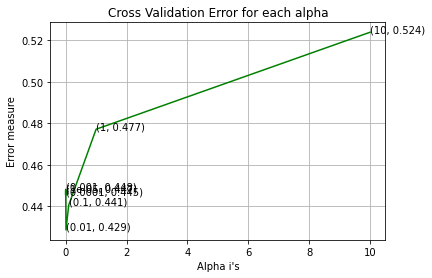

For values of best alpha =  0.01 The train log loss is: 0.42595377633312403
For values of best alpha =  0.01 The test log loss is: 0.4286579817566739
Total number of data points : 40025


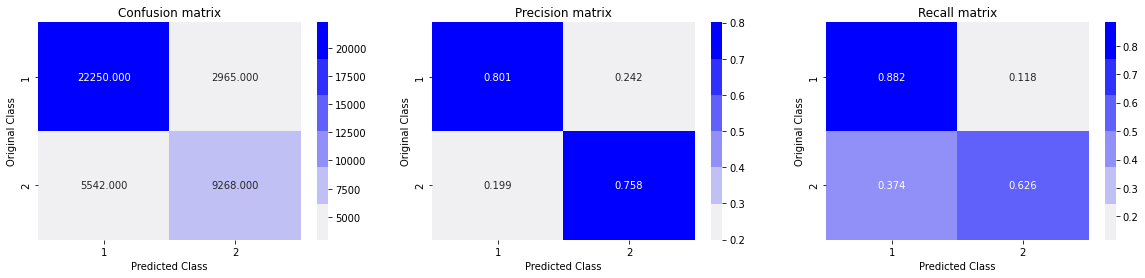

In [9]:
#Logistic Regression with hyperparameter tuning 
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)